In [0]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
import math
%matplotlib inline


In [0]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


In [0]:
rgb_img = plt.imread("china.jpg")
gray_img = rgb2gray(rgb_img)


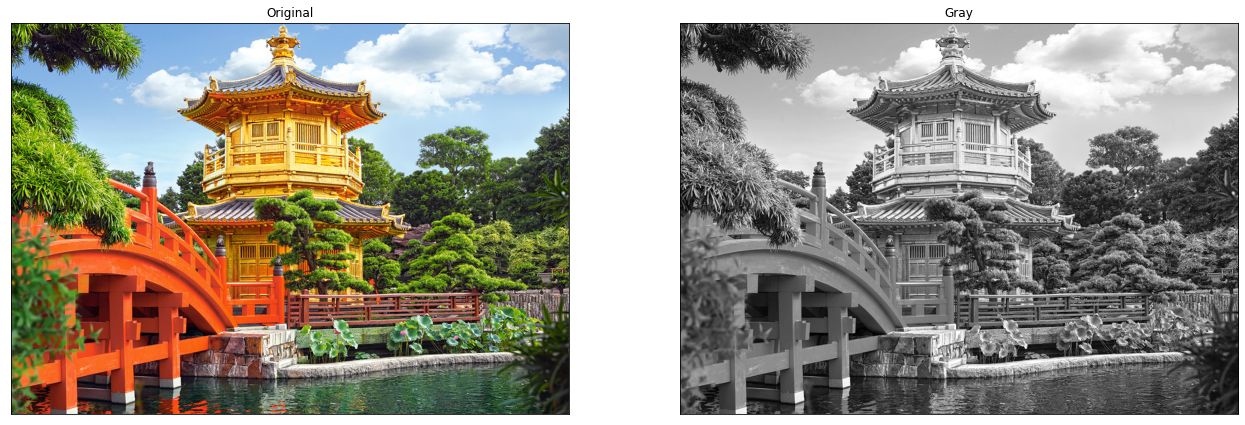

In [66]:
plt.figure(figsize=(22,12))
plt.subplot(121)
plt.imshow(rgb_img)
plt.title("Original")
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(gray_img, cmap='gray')
plt.title("Gray")
plt.xticks([])
plt.yticks([])
plt.show()

In [0]:
s = 3
num_octave = 4 
s0 = 1.3
sigma = 1.6
r_th = 10
t_c = 0.03
w = 16
R_th = (r_th+1)**2 / r_th

In [0]:
def gaussian_filter(sigma):
  size = 2 * np.ceil(3 * sigma) + 1
  # print(size, size//2, size // 2 + 1)
  x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
  g = np.exp(-((x**2 + y**2)/(2.0*sigma**2))) / (2*np.pi*sigma**2)
  # print(x)
  # print(y)
  # print(g)
  # print(g/g.sum())
  return g/g.sum()


In [0]:
def convolve(img, filter):
  k = int(len(filter) / 2)
  row = len(img)
  col = len(img[0])
  # print(k, row, col)
  new_img = img.copy()
  for i in range(k, row - k):
    for j in range(k, col - k):
      pixel_matrix = img[i - k : i + k + 1, j - k : j + k + 1]
      val = pixel_matrix * filter
      new_img[i][j] = val.sum()
  return new_img


In [0]:
img = gray_img


In [0]:
def generate_octave(im):
  octave = []
  k = 2 ** (1 / 2)
  kernel = gaussian_filter(k * sigma)
  for i in range(s + 2):
    if(i == 0):
        next_img = convolve(im, kernel)
        octave.append(next_img)
    else:
        next_img = convolve(octave[-1], kernel)
        octave.append(next_img)
  return octave

In [0]:
def generate_gaussian_pyramid(img):
  pyramid = []
  im = img.copy()
  for i in range(num_octave):
    octave = generate_octave(im)
    pyramid.append(octave)
    im = octave[-3][::2, ::2]
  return pyramid


In [0]:
gaussian_pyramid = generate_gaussian_pyramid(img)

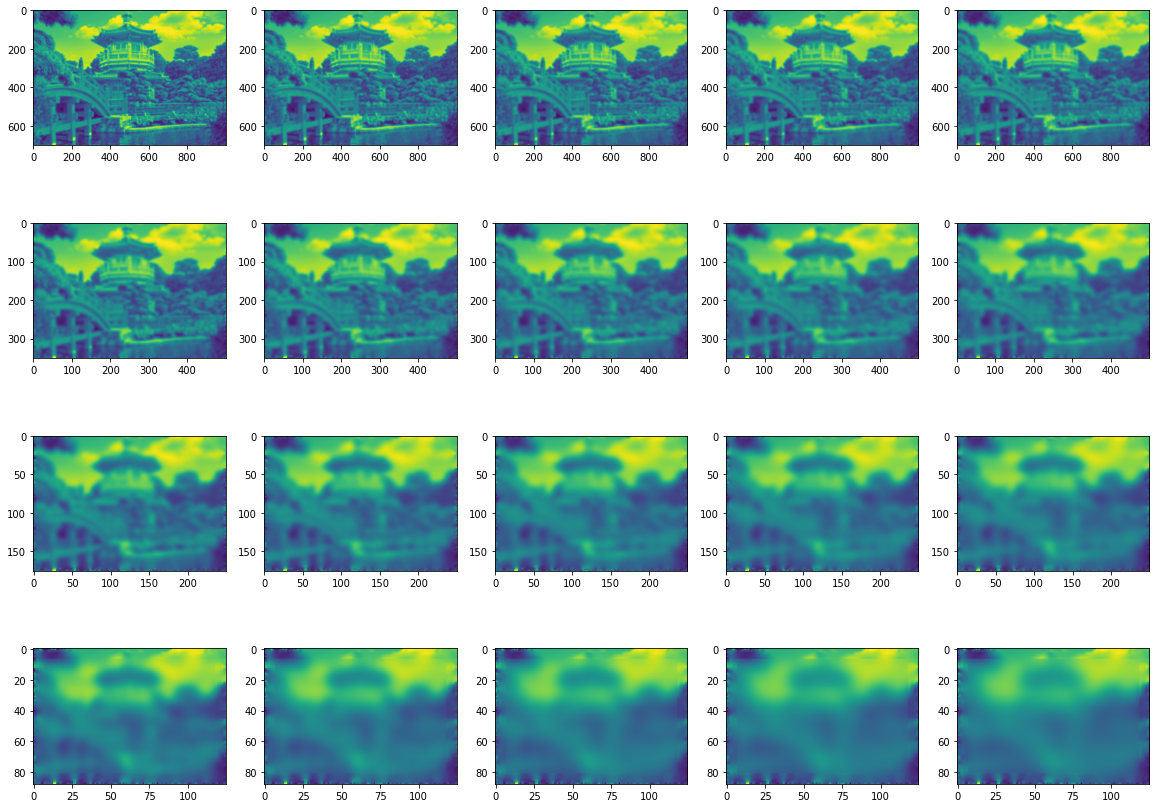

In [74]:
r = len(gaussian_pyramid)
c = len(gaussian_pyramid[0])
f, axarr = plt.subplots(r, c)
f.set_figwidth(20)
f.set_figheight(15)
for i in range(r):
  for j in range(c):
    axarr[i,j].imshow(gaussian_pyramid[i][j])


In [0]:
def generate_DOG_octave(gaussian_octave):
  DOG_octave = []
  for i in range(1, len(gaussian_octave)):
    diff = gaussian_octave[i] - gaussian_octave[i - 1]
    # print(len(diff), len(diff[0]))
    DOG_octave.append(diff)
    
  return DOG_octave

In [0]:
def generate_DOG_pyramid(gaussian_pyramid):
  DOG_pyramid = []
  for gaussian_octave in gaussian_pyramid:
    DOG_pyramid.append(generate_DOG_octave(gaussian_octave=gaussian_octave))
  return DOG_pyramid

In [0]:
DOG_pyramid = generate_DOG_pyramid(gaussian_pyramid)

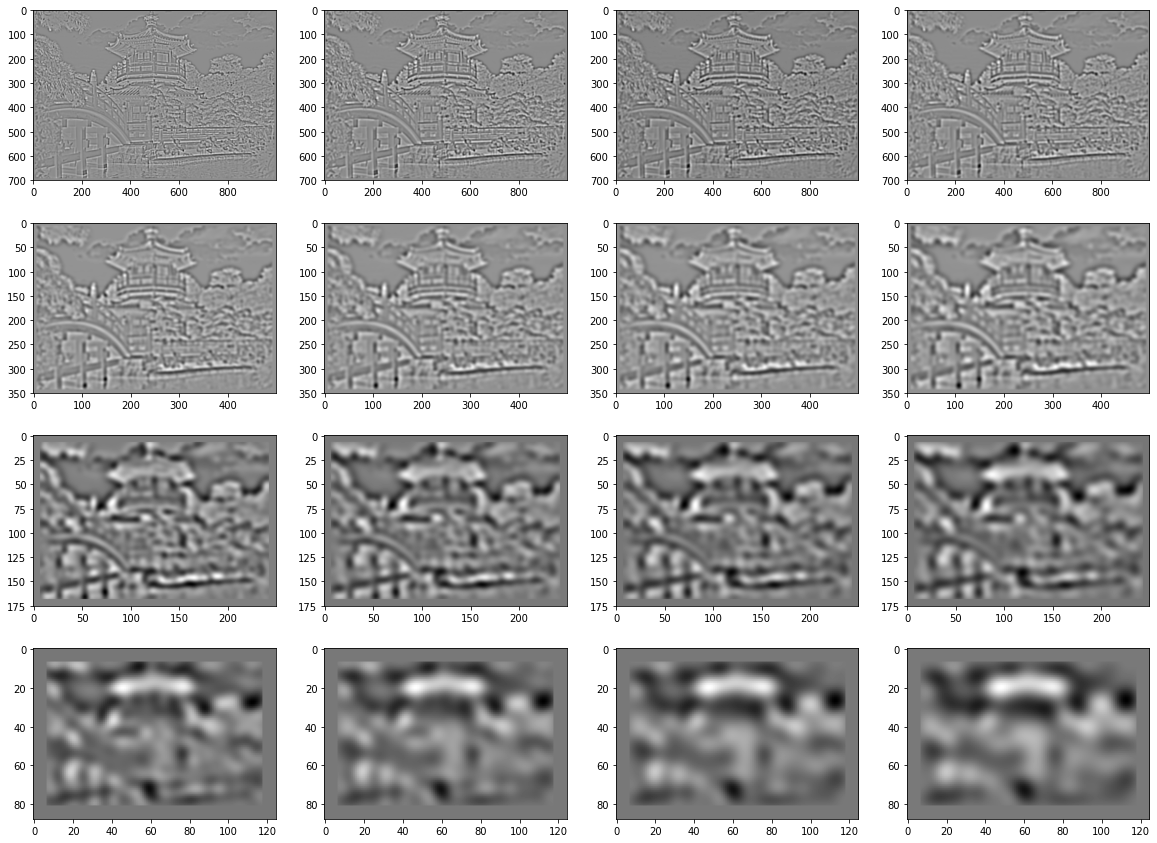

In [78]:
r = len(DOG_pyramid)
c = len(DOG_pyramid[0])
# print(r, c)
f, axarr = plt.subplots(r, c)
f.set_figwidth(20)
f.set_figheight(15)
for i in range(r):
  for j in range(c):
    axarr[i,j].imshow(DOG_pyramid[i][j], cmap='gray')

In [0]:
def update_dimension_of_DOG_octave(DOG_pyramid):
  pyramid = []
  for DOG_octave in DOG_pyramid:
    D = np.concatenate([octave[:,:,np.newaxis] for octave in DOG_octave], axis=2)
    pyramid.append(D)
  return pyramid

In [0]:
DOG_pyramid = update_dimension_of_DOG_octave(DOG_pyramid)

In [0]:
def get_candidate_keypoints(D, w=16):
	candidates = []

	''' Start '''
	# These 2 lines aren't specified in the paper but it makes it so the extrema
	# are found within the entire octave. They are always found in the first or
	# last layer so I probably have something wrong with my DoG pyramid construction.
	D[:,:,0] = 0
	D[:,:,-1] = 0
	''' End '''
	
	# have to start at w//2 so that when getting the local w x w descriptor, we don't fall off
	for i in range(w//2+1, D.shape[0]-w//2-1):
		for j in range(w//2+1, D.shape[1]-w//2-1):
			for k in range(1, D.shape[2]-1): 
				patch = D[i-1:i+2, j-1:j+2, k-1:k+2]
				if np.argmax(patch) == 13 or np.argmin(patch) == 13:
					candidates.append([i, j, k])

	return candidates

In [0]:
def localize_keypoint(D, x, y, s):
	dx = (D[y,x+1,s]-D[y,x-1,s])/2.
	dy = (D[y+1,x,s]-D[y-1,x,s])/2.
	ds = (D[y,x,s+1]-D[y,x,s-1])/2.

	dxx = D[y,x+1,s]-2*D[y,x,s]+D[y,x-1,s]
	dxy = ((D[y+1,x+1,s]-D[y+1,x-1,s]) - (D[y-1,x+1,s]-D[y-1,x-1,s]))/4.
	dxs = ((D[y,x+1,s+1]-D[y,x-1,s+1]) - (D[y,x+1,s-1]-D[y,x-1,s-1]))/4.
	dyy = D[y+1,x,s]-2*D[y,x,s]+D[y-1,x,s]
	dys = ((D[y+1,x,s+1]-D[y-1,x,s+1]) - (D[y+1,x,s-1]-D[y-1,x,s-1]))/4.
	dss = D[y,x,s+1]-2*D[y,x,s]+D[y,x,s-1]

	J = np.array([dx, dy, ds])
	HD = np.array([
		[dxx, dxy, dxs],
		[dxy, dyy, dys],
		[dxs, dys, dss]])
	
	offset = -LA.inv(HD).dot(J)	
	return offset, J, HD[:2,:2], x, y, s


In [0]:
def find_keypoints_for_DoG_octave(D, w):
	candidates = get_candidate_keypoints(D, w=w)

	keypoints = []

	for i, cand in enumerate(candidates):
		y, x, s = cand[0], cand[1], cand[2]
		offset, J, H, x, y, s = localize_keypoint(D, x, y, s)

		contrast = D[y,x,s] + .5*J.dot(offset)
		if abs(contrast) < t_c: continue

		w, v = LA.eig(H)
		r = w[1]/w[0]
		R = (r+1)**2 / r
		if R > R_th: continue

		kp = np.array([x, y, s]) + offset
		if kp[1] >= D.shape[0] or kp[0] >= D.shape[1]: continue # throw out boundary points because I don't want to deal with them

		keypoints.append(kp)

	#print('%d keypoints found' % len(keypoints))
	return np.array(keypoints)

In [0]:
def get_keypoints(DOG_pyramid):
    keypoints = []

    for DOG_octave in DOG_pyramid:
        keypoints.append(find_keypoints_for_DoG_octave(DOG_octave, w))

    return keypoints

In [0]:
keypoints_pyramid = get_keypoints(DOG_pyramid)

In [0]:
def cart_to_polar_grad(dx, dy):
    m = np.sqrt(dx**2 + dy**2)
    theta = (np.arctan2(dy, dx)+np.pi) * 180/np.pi
    return m, theta

def get_grad(L, x, y):
    dy = L[min(L.shape[0]-1, y+1),x] - L[max(0, y-1),x]
    dx = L[y,min(L.shape[1]-1, x+1)] - L[y,max(0, x-1)]
    return cart_to_polar_grad(dx, dy)

def quantize_orientation(theta, num_bins):
    bin_width = 360//num_bins
    return int(np.floor(theta)//bin_width)

def fit_parabola(hist, binno, bin_width):
    centerval = binno*bin_width + bin_width/2.

    if binno == len(hist)-1: rightval = 360 + bin_width/2.
    else: rightval = (binno+1)*bin_width + bin_width/2.

    if binno == 0: leftval = -bin_width/2.
    else: leftval = (binno-1)*bin_width + bin_width/2.
    
    A = np.array([
        [centerval**2, centerval, 1],
        [rightval**2, rightval, 1],
        [leftval**2, leftval, 1]])
    b = np.array([
        hist[binno],
        hist[(binno+1)%len(hist)], 
        hist[(binno-1)%len(hist)]])

    x = LA.lstsq(A, b, rcond=None)[0]
    if x[0] == 0: x[0] = 1e-6
    return -x[1]/(2*x[0])

def assign_orientation(kps, octave, num_bins=36):
    new_kps = []
    bin_width = 360//num_bins

    for kp in kps:
        cx, cy, s = int(kp[0]), int(kp[1]), int(kp[2])
        s = np.clip(s, 0, octave.shape[2]-1)

        sigma = abs(kp[2])*1.5
        w = int(2*np.ceil(sigma)+1)
        kernel = gaussian_filter(sigma)

        L = octave[...,s]
        hist = np.zeros(num_bins + 1, dtype=np.float32)
        kl = len(kernel)
        for oy in range(-w, w+1):
            for ox in range(-w, w+1):
                x, y = cx+ox, cy+oy
                
                if x < 0 or x > octave.shape[1]-1: continue
                elif y < 0 or y > octave.shape[0]-1: continue
                elif(oy+w >=kl or ox+w>=kl): continue
                m, theta = get_grad(L, x, y)
                weight = kernel[oy+w, ox+w] * m

                bin = quantize_orientation(theta, num_bins)
                hist[bin] += weight

        max_bin = np.argmax(hist)
        new_kps.append([kp[0], kp[1], kp[2], fit_parabola(hist, max_bin, bin_width)])

        max_val = np.max(hist)
        for binno, val in enumerate(hist):
            if binno == max_bin: continue

            if .8 * max_val <= val:
                new_kps.append([kp[0], kp[1], kp[2], fit_parabola(hist, binno, bin_width)])

    return np.array(new_kps)

In [0]:
keypoints_orientation = []
for i, DoG_octave in enumerate(DOG_pyramid):
  kpr_orientation = assign_orientation(keypoints_pyramid[i], DoG_octave)
  keypoints_orientation.append(kpr_orientation)


In [0]:
def get_patch_grads(p):
    r1 = np.zeros_like(p)
    r1[-1] = p[-1]
    r1[:-1] = p[1:]

    r2 = np.zeros_like(p)
    r2[0] = p[0]
    r2[1:] = p[:-1]

    dy = r1-r2
    if(len(r1) != 0 and len(r1[0]) != 0):
      r1[:,-1] = p[:,-1]
      r1[:,:-1] = p[:,1:]
    if(len(r2) != 0 and len(r2[0] != 0)):
      r2[:,0] = p[:,0]
      r2[:,1:] = p[:,:-1]

    dx = r1-r2

    return dx, dy

def get_histogram_for_subregion(m, theta, num_bin, reference_angle, bin_width, subregion_w):
    hist = np.zeros(num_bin, dtype=np.float32)
    c = subregion_w/2 - .5

    for i, (mag, angle) in enumerate(zip(m, theta)):
        angle = (angle-reference_angle) % 360
        binno = quantize_orientation(angle, num_bin)
        vote = mag

        # binno*bin_width is the start angle of the histogram bin
        # binno*bin_width+bin_width/2 is the center of the histogram bin
        # angle - " is the distance from the angle to the center of the bin 
        hist_interp_weight = 1 - abs(angle - (binno*bin_width + bin_width/2))/(bin_width/2)
        vote *= max(hist_interp_weight, 1e-6)

        gy, gx = np.unravel_index(i, (subregion_w, subregion_w))
        x_interp_weight = max(1 - abs(gx - c)/c, 1e-6)
        y_interp_weight = max(1 - abs(gy - c)/c, 1e-6)
        vote *= x_interp_weight * y_interp_weight

        hist[binno] += vote

    return hist


In [0]:
def get_local_descriptors(kps, octave, w=16, num_subregion=4, num_bin=8):
  descs = []
  bin_width = 360//num_bin
  gg = 0
  for kp in kps:
    cx, cy, s = int(kp[0]), int(kp[1]), int(kp[2])
    s = np.clip(s, 0, octave.shape[2]-1)
    kernel = gaussian_filter(w/6) # gaussian_filter multiplies sigma by 3
    kernel = np.array(kernel)
    # w = int(2*np.ceil(w/6) + 1)
    L = octave[...,s]
    t, l = max(0, cy-w//2), max(0, cx-w//2)
    b, r = min(L.shape[0], cy+w//2+1), min(L.shape[1], cx+w//2+1)
    patch = L[t:b, l:r]
    gg = gg + 1
    dx, dy = get_patch_grads(patch)
    # print(gg, t, l, b, r)
    if(dx.shape[0] < w+1):
      if(t == 0):
        kernel = kernel[abs(kernel.shape[0]-dx.shape[0]):]
      else:
        kernel = kernel[:dx.shape[0]]
    if dx.shape[1] < w+1:
      if(l == 0):
        kernel = kernel[:,abs(kernel.shape[1]-dx.shape[1]):]
      else:
        kernel = kernel[:, :dx.shape[1]]

    if(dy.shape[0] < w+1):
      if(t == 0):
        kernel = kernel[abs(kernel.shape[0]-dy.shape[0]):]
      else:
        kernel = kernel[:dy.shape[0]]
    if(dy.shape[1] < w+1):
      if(l == 0):
        kernel = kernel[:,abs(kernel.shape[1]-dy.shape[1]):]
      else:
        kernel = kernel[:dy.shape[1]]
    m, theta = cart_to_polar_grad(dx, dy)
    u,v = kernel.shape
    if(dx.shape[0]>u):
      dx=dx[dx.shape[0]-u:]
    if(dx.shape[1]>v):
      dx=dx[:,dx.shape[1]-v]
    
    if(dy.shape[0]>u):
      dy=dy[dy.shape[0]-u:]
    if(dy.shape[1]>v):
      dy=dy[:,dy.shape[1]-v]

    # print(dx.shape, kernel.shape)
    ddx = dx*kernel
    ddy = dy*kernel
    subregion_w = w//num_subregion
    featvec = np.zeros(num_bin * num_subregion**2, dtype=np.float32)

    for i in range(0, subregion_w):
      for j in range(0, subregion_w):
        t, l = i*subregion_w, j*subregion_w
        b, r = min(L.shape[0], (i+1)*subregion_w), min(L.shape[1], (j+1)*subregion_w)

        hist = get_histogram_for_subregion(m[t:b, l:r].ravel(), 
                                        theta[t:b, l:r].ravel(), 
                                        num_bin, 
                                        kp[3], 
                                        bin_width,
                                        subregion_w)
        featvec[i*subregion_w*num_bin + j*num_bin:i*subregion_w*num_bin + (j+1)*num_bin] = hist.flatten()

    featvec /= max(1e-6, LA.norm(featvec))
    featvec[featvec>0.2] = 0.2
    featvec /= max(1e-6, LA.norm(featvec))
    descs.append(featvec)

  return np.array(descs)

In [0]:
feats = []
for i, DoG_octave in enumerate(DOG_pyramid):
  feats.append(get_local_descriptors(keypoints_orientation[i], DoG_octave))


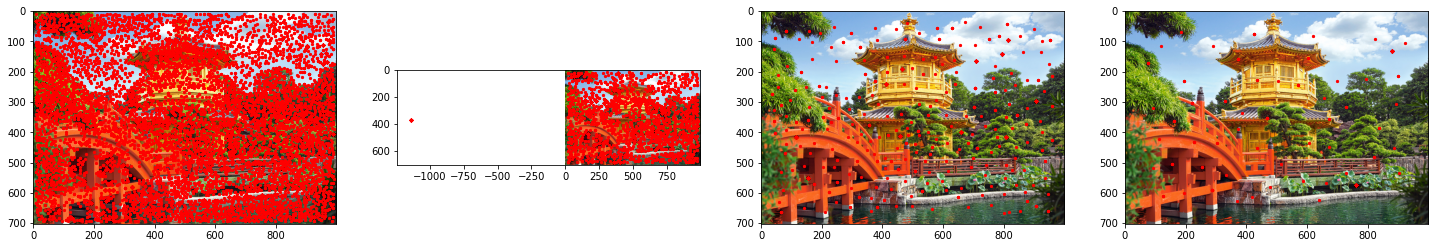

In [91]:
fi, ax = plt.subplots(1, num_octave)
fi.set_figwidth(25)
fi.set_figheight(20)	
for i in range(len(keypoints_orientation)):
  ax[i].imshow(rgb_img)
  scaled_kps = keypoints_orientation[i] * (2**i)
  r = scaled_kps.shape[0]
  if(r == 0):
    continue
  c = scaled_kps.shape[1]
  if(c == 0):
    continue
  ax[i].scatter(scaled_kps[:,0], scaled_kps[:,1], c='r', s=5)
plt.show()